In [3]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd

df_matches = pd.read_csv("matches.csv")
df_matches.head(2)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN


In [4]:
df_deliveries = pd.read_csv("deliveries.csv")
df_deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN


In [5]:
print(df_matches.shape)
print(df_deliveries.shape)

(756, 18)
(179078, 21)


In matches data frame columns like umpire1,umpire2,umpire3 are not useful because these days they are using technology. So we cant decide which umpire is more useful for predicting anything related to match.

Date is also not useful because we already have season column which is also almost equal to date.

City and venue also not important features for this year IPL. Because IPL2020 is happening in UAE, only 2014 ipl was happened in UAE that to half season. But i am removing only venue it almost equal to city feature.

'Result' feature is almost equal to 'winner' feature. So i am dropping result column also.

In [6]:
df_matches = df_matches.drop(['venue','date','result','umpire1','umpire2','umpire3'], axis = 1) 
df_matches.head(2)

,id,season,city,team1,team2,toss_winner,toss_decision,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match
0,1,2017,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,0,Sunrisers Hyderabad,35,0,Yuvraj Singh
1,2,2017,Pune,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,0,Rising Pune Supergiant,0,7,SPD Smith


In [7]:
print(df_matches["team1"].value_counts())

Mumbai Indians                 101
Kings XI Punjab                 91
Chennai Super Kings             89
Royal Challengers Bangalore     85
Kolkata Knight Riders           83
Delhi Daredevils                72
Rajasthan Royals                67
Sunrisers Hyderabad             63
Deccan Chargers                 43
Pune Warriors                   20
Gujarat Lions                   14
Rising Pune Supergiant           8
Rising Pune Supergiants          7
Kochi Tuskers Kerala             7
Delhi Capitals                   6
Name: team1, dtype: int64


In [8]:
#In 2019 delhi daredevils name changed to delhi capitals. So i am replacing old name with new name for all the rows.
df_matches = df_matches.replace(to_replace ="Delhi Daredevils", value = "Delhi Capitals") 

df_deliveries = df_deliveries.replace(to_replace = "Delhi Daredevils", value = "Delhi Capitals")

#Rising pune supergiants name also printed in two ways. Lets change it to Rising pune supergiants.
df_matches = df_matches.replace(to_replace ="Rising Pune Supergiant", value = "Rising Pune Supergiants") 

df_deliveries = df_deliveries.replace(to_replace = "Rising Pune Supergiant", value = "Rising Pune Supergiants")

In [9]:
#checking null values in matches dataset
print(df_matches.isnull().sum())

id                 0
season             0
city               7
team1              0
team2              0
toss_winner        0
toss_decision      0
dl_applied         0
winner             4
win_by_runs        0
win_by_wickets     0
player_of_match    4
dtype: int64


In [10]:
#printing null rows in matches dataset
df1_null = df_matches[df_matches.isna().any(axis=1)]
df1_null.head(2)

,id,season,city,team1,team2,toss_winner,toss_decision,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match
300,301,2011,Delhi,Delhi Capitals,Pune Warriors,Delhi Capitals,bat,0,NaN,0,0,NaN
461,462,2014,NaN,Mumbai Indians,Royal Challengers Bangalore,Royal Challengers Bangalore,field,0,Royal Challengers Bangalore,0,7,PA Patel


In [11]:
#After seeing above table we can clearly understood that 4 matches are not played beacuse of rain, badlight or pitch condition. 
#So i am replacing those null values in winner column with no result and palyer of the match column null values with not declared.
df_matches["winner"].fillna("No result", inplace = True)
df_matches['player_of_match'].fillna("Not declared", inplace = True)
#city column also has 7 null values. I checked those matches data in Espn website and they played in Dubai.
df_matches["city"].fillna("Dubai", inplace = True)
print(df_matches.shape)

(756, 12)


In [12]:
#checking null values in deliveries dataset
print(df_deliveries.isnull().sum())

match_id                 0
inning                   0
batting_team             0
bowling_team             0
over                     0
ball                     0
batsman                  0
non_striker              0
bowler                   0
is_super_over            0
wide_runs                0
bye_runs                 0
legbye_runs              0
noball_runs              0
penalty_runs             0
batsman_runs             0
extra_runs               0
total_runs               0
player_dismissed    170244
dismissal_kind      170244
fielder             172630
dtype: int64


Player_dismissed, dismissal_kind and fielder features are having null values. But if you consider today questions only 'player_dismissed' and 'dismissal_kind' features are useful for today analysis. So i am removing "fielder" feature.

Filling player_dismissed null values with 'No wicket', didmissal_Kind null values with also No Wicket

In [13]:
#dropping fielder column
df_deliveries = df_deliveries.drop(['fielder'], axis = 1) 
#filling null values
df_deliveries["player_dismissed"].fillna("No Wicket", inplace = True)
df_deliveries["dismissal_kind"].fillna("No Wicket", inplace = True)
df_deliveries.head(2)

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,wide_runs,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,No Wicket,No Wicket
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,0,0,0,0,0,0,0,0,No Wicket,No Wicket


In [14]:
df_total = pd.merge(df_matches, df_deliveries, left_on='id',right_on='match_id', how='outer')

### Q1) Who will win today match RCB VS KKR?

In [15]:
# Lets check winning ratio between RCB VS KKR
df_RCB_KKR = df_matches[((df_matches['team1'] == 'Royal Challengers Bangalore') | (df_matches['team1'] == 'Kolkata Knight Riders')) & 
                         ((df_matches['team2'] == 'Royal Challengers Bangalore') | (df_matches['team2'] == 'Kolkata Knight Riders'))] 

#plotting RCB and KKR wins against each other
import plotly.graph_objs as go
df_winner = df_RCB_KKR[['id','winner']].groupby('winner').size().reset_index()
df_winner.columns = ['winner','total_wins']
df_winner = df_winner.sort_values('total_wins',ascending=False)

data = go.Bar(x = df_winner['winner'],y = df_winner['total_wins'])
layout = go.Layout(title = 'Number of wins by RCB and KKR against each other',xaxis = dict(title = 'Team'),yaxis = dict(title = 'No of wins'))
fig = go.Figure(data = data,layout = layout)
fig.show()

In [16]:
# Lets check winning ratio between RCB VS KKR in 2019 season
df_RCB_KKR_2019 = df_matches[((df_matches['team1'] == 'Royal Challengers Bangalore') | (df_matches['team1'] == 'Kolkata Knight Riders')) & 
                         ((df_matches['team2'] == 'Royal Challengers Bangalore') | (df_matches['team2'] == 'Kolkata Knight Riders')) &
                         (df_matches['season'] == 2019)] 

#plotting RCB and KKR wins against each other in last year IPL
import plotly.graph_objs as go
df_winner = df_RCB_KKR_2019[['id','winner']].groupby('winner').size().reset_index()
df_winner.columns = ['winner','total_wins']
df_winner = df_winner.sort_values('total_wins',ascending=False)

data = go.Bar(x = df_winner['winner'],y = df_winner['total_wins'])
layout = go.Layout(title = 'Number of wins by RCB and KKR against each other in 2019 season',xaxis = dict(title = 'Team'),yaxis = dict(title = 'No of wins'))
fig = go.Figure(data = data,layout = layout)
fig.show()

KKR won 4 more matches than RCB, but in last season both won 1 match each. Lets look at individul performance as well. 

In [17]:
#Lets look at how many player of the match awards won by current RCB and KXIP players.
#Note: I am taking top 8 palyers from both teams
#Sometimes team win dependent on Number of match winners in your team. i.e why i am using this approach.
#Note: I am taking these player names because these players are played atleast one match for their respective sides in this season till now.
df_man_of_match_RCB = df_matches[(df_matches['player_of_match'] == 'V Kohli') | (df_matches['player_of_match'] == 'A Finch') |
                                (df_matches['player_of_match'] == 'AB de Villiers') | (df_matches['player_of_match'] == 'S Dube') |
                                (df_matches['player_of_match'] == 'YS Chahal') | (df_matches['player_of_match'] == 'CH Morris') |
                                (df_matches['player_of_match'] == 'Washington Sundar') | (df_matches['player_of_match'] == 'N Saini')]


print("Total number of man of matches won by present Bangalore players is", df_man_of_match_RCB.shape[0],"\n")

df_man_of_match_KKR = df_matches[(df_matches['player_of_match'] == 'KD Karthik') | (df_matches['player_of_match'] == 'AD Russell') |
                                (df_matches['player_of_match'] == 'PJ Cummins') | (df_matches['player_of_match'] == 'SP Narine') |
                                (df_matches['player_of_match'] == 'EJG Morgan') | (df_matches['player_of_match'] == 'N Rana') |
                                (df_matches['player_of_match'] == 'S Gill') | (df_matches['player_of_match'] == 'Kuldeep Yadav')]


print("Total number of man of matches won by present KKR players is", df_man_of_match_KKR.shape[0])


Total number of man of matches won by present Bangalore players is 36 

Total number of man of matches won by present KKR players is 31


**Conclusion :-**

RCB players won more man of the match awards than KKR player, So i can say RCB has more match winners. I am predicting RCB will win today match

### Q2) How many wickets will RCB loose in between 31st ball and 120th ball.

In [24]:
#First filter out RCB team from overs 6 to 20 with wickets
df_RCB_wickets = df_deliveries[(df_deliveries['batting_team'] == 'Royal Challengers Bangalore') & (df_deliveries['over'] >= 6) &
                               (df_deliveries['player_dismissed'] != 'No Wicket')]

#Calculating number wickets per match
no_of_wickets = df_RCB_wickets.groupby('match_id')['player_dismissed'].count()
#Converting series object to dataframe
df_wickets_by_match['number_of_players_dismissed'] = no_of_wickets.to_frame()
df_wickets_by_match = df_wickets_by_match.drop(['player_dismissed'],axis=1)
df_wickets_by_match.head(2)

,number_of_players_dismissed
match_id,
1,10
5,7


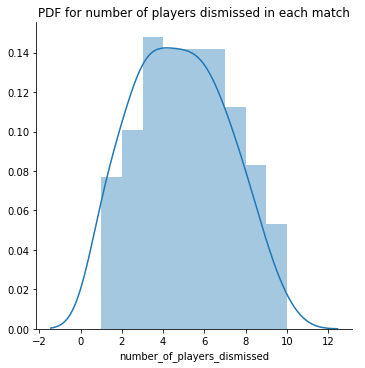

In [26]:
#Now plotting PDF 
import seaborn as sns
import matplotlib.pyplot as plt
sns.FacetGrid(df_wickets_by_match,size=5) \
   .map(sns.distplot, "number_of_players_dismissed") \
   .add_legend();

plt.title("PDF for number of players dismissed in each match")
plt.show();

**Conclusion :-**

If you look at above plot clearly probability of number of players dismissed = 4 is very high i.e more than 0.14(14%).

So i am predicting in today match RCB will loose 4 wickets from 31st ball to 120th ball.

### Q3) How many balls will Ab De Villiers to take score 30 runs? 

In [149]:
#Filter out abd runs
df_ABD = df_deliveries[(df_deliveries['batsman'] == 'AB de Villiers') & (df_deliveries['wide_runs'] == 0)]

#converting batsman runs, balls faced, match id into list
batsman_runs_list = df_ABD['batsman_runs'].tolist()
match_id_list = df_ABD['match_id'].tolist()
balls_list = df_ABD['ball'].tolist()

listoflists = []
listoflists.append(match_id_list)
listoflists.append(batsman_runs_list)
listoflists.append(balls_list)

ABD_ballsfaced = []
ABD_matchID = []
sum = 0
balls_faced = 0
for i in range(len(listoflists[0])-1):
     sum = sum + (listoflists[1][i])
     balls_faced = balls_faced + 1
     if listolists[0][i] not in ABD_matchID:   
        if sum >= 30:
           ABD_ballsfaced.append(balls_faced)
           ABD_matchID.append(listoflists[0][i])
           sum = 0
           balls_faced = 0

#Printing number of balls faced for 30runs and corresponding match_Id
print(ABD_ballsfaced)
print(ABD_matchID)     

[25, 25, 28, 37, 22, 23, 24, 27, 35, 32, 48, 26, 38, 48, 33, 36, 67, 35, 33, 34, 36, 35, 48, 38, 51, 22, 28, 31, 25, 54, 10, 27, 41, 18, 37, 26, 57, 36, 33, 20, 37, 11, 34, 48, 14, 57, 23, 11, 50, 21, 25, 48, 56, 47, 42, 61, 51, 15, 26, 61, 26, 16, 53, 24, 19, 81, 16, 15, 60, 11, 58, 14, 77, 23, 14, 90, 24, 13, 77, 18, 71]
[8, 12, 17, 33, 37, 45, 79, 93, 104, 125, 129, 133, 150, 154, 158, 165, 167, 172, 180, 189, 197, 237, 242, 248, 268, 291, 296, 306, 312, 329, 329, 333, 350, 356, 392, 396, 401, 420, 432, 438, 448, 452, 462, 481, 481, 492, 492, 495, 506, 522, 525, 540, 546, 557, 562, 574, 587, 587, 590, 595, 603, 603, 617, 620, 620, 633, 633, 633, 7901, 7901, 7912, 7917, 7944, 7944, 7946, 11150, 11153, 11311, 11322, 11322, 11337]


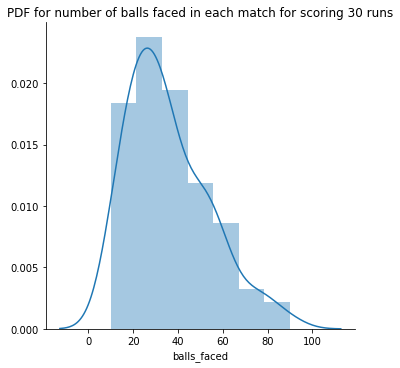

median =  33.0


In [150]:
#converting above two kists into dataframe
df_ABD_ballsfaced_30runs =  pd.DataFrame(list(zip(ABD_matchID, ABD_ballsfaced)), columns =['match_id', 'balls_faced']) 

#Now plotting PDF 
sns.FacetGrid(df_ABD_ballsfaced_30runs,size=5) \
   .map(sns.distplot, "balls_faced") \
   .add_legend();

plt.title("PDF for number of balls faced in each match for scoring 30 runs")
plt.show();

**Conclusion :-**

By looking at above PDF plot i can say that Probability is very high for balls faced = 20 to 26.

So i am predicting in today match he will score 30 runs in 18 to 24 balls, because this is very close option to above analysis.

### Q4)What will be the difference in Eoin Morgan overall Strike rate and the Strike rate of last 7 balls he faced.

In [158]:
#Calculating Morgan overall strike rate in each match
df_Morgan = df_deliveries[df_deliveries['batsman'] == 'EJG Morgan']

Runs_scored = df_Morgan.groupby('match_id')['batsman_runs'].sum()
balls_faced = df_Morgan.groupby('match_id')['ball'].count()
morgan_strike_rate = (Runs_scored/balls_faced)*100
df_morgan_strike_rate['Strike_rate'] = morgan_strike_rate.to_frame()
df_morgan_strike_rate.head(6)

overall_strkrate = df_morgan_strike_rate.mean()
print(overall_strkrate)

Strike_rate    102.772298
dtype: float64


In [151]:
#Calculating Morgan Strike rate in last 7 balls in each match
# runs_scored = df_Morgan.groupby('match_id')
#converting batsman runs, balls faced, match id into list
import numpy as np
batsman_runs_list = df_Morgan['batsman_runs'].tolist()
batsman_runs_list = np.flipud(batsman_runs_list)
match_id_list = df_Morgan['match_id'].tolist()
match_id_list = np.flipud(match_id_list)
balls_list = df_Morgan['ball'].tolist()
balls_list = np.flipud(balls_list)

listoflists = []
listoflists.append(match_id_list)
listoflists.append(batsman_runs_list)
listoflists.append(balls_list)

morgan_runs = []
morgan_matchID = []
sum = 0
balls_faced = 0
for i in range(724):
     sum = sum + (listoflists[1][i])
     balls_faced = balls_faced + 1
     if listolists[0][i] not in morgan_matchID:   
        if balls_faced == 7 :
           morgan_runs.append(sum)
           morgan_matchID.append(listoflists[0][i])
           sum = 0
           balls_faced = 0

#Printing number of balls faced for 30runs and corresponding match_Id
print(morgan_runs)
print(morgan_matchID)  
print(len(listoflists[2]))

df_morgan_last7balls =  pd.DataFrame(list(zip(morgan_matchID, morgan_runs)), columns =['match_id', 'runs_scored']) 
df_morgan_last7balls.head(2)

[11, 7, 12, 3, 7, 8, 11, 10, 15, 5, 5, 5, 7, 9, 8, 9, 0, 10, 18, 3, 8, 10, 7, 17, 22, 15, 3, 4, 4, 15, 4, 8, 3, 8, 7, 11, 1, 7, 5, 11, 3, 3, 10, 4, 12, 8, 14, 8, 16, 11, 11, 6, 4, 11, 2, 7, 11, 11, 11, 6, 8, 18, 16, 4, 4, 14, 15, 15, 2, 3, 5, 5, 6, 3, 6, 13, 4, 11, 14, 8, 6, 8, 2, 4, 13, 16, 7, 8, 7, 7, 8, 9, 3, 5, 10, 13, 11, 4, 4, 3, 12]
[628, 594, 594, 594, 588, 588, 584, 584, 584, 584, 584, 584, 580, 580, 580, 572, 572, 568, 564, 561, 561, 561, 558, 558, 558, 558, 558, 555, 551, 551, 551, 551, 529, 529, 529, 529, 529, 453, 437, 437, 434, 424, 424, 418, 418, 418, 415, 415, 415, 415, 413, 413, 413, 413, 406, 400, 400, 400, 400, 400, 397, 397, 397, 397, 389, 389, 389, 389, 389, 389, 382, 382, 291, 281, 278, 278, 278, 278, 278, 278, 278, 278, 275, 275, 270, 270, 258, 255, 255, 235, 197, 197, 188, 178, 54, 32, 32, 32, 19, 19, 15]
725


,match_id,runs_scored
0,628,11
1,594,7


In [159]:
runs = df_morgan_last7balls['runs_scored'].sum()
balls_faced = df_morgan_last7balls['match_id'].nunique()
strike_rate = (runs/(balls_faced*7))*100
print("Strike rate in last 7 balls is",strike_rate)

result = strike_rate - overall_strkrate
print(result)

Strike rate in last 7 balls is 298.57142857142856
Strike_rate    195.79913
dtype: float64


By looking at above analysis i am predicting his strike rate in diffrence between overall and last 7 balls is 151 or more.

### Q5)How many Runs will RCB score of KKR in death?

Death overs are 16 to 20

In [137]:
df_deathovers = df_deliveries[(df_deliveries['batting_team'] == 'Royal Challengers Bangalore') &(df_deliveries['over'] >= 16)]
df_deathovers.head()
runs_scored = df_deathovers['total_runs'].sum()
matches_played = df_deathovers['match_id'].nunique()
average_runs_per_match = runs_scored/matches_played
print("Averae runs scored by RCB in death",int(average_runs_per_match))

runs_scored = df_deathovers.groupby('match_id')['total_runs'].sum()
print("Median :",runs_scored.median())

Averae runs scored by RCB in death 47
Median : 48.0


**Conclusion :-**

I claculated both average runs scored by RCB in death then calcualted median of runs scored by RCB in death both got almost equal i.e 47 and 48. In today match as well they will score 46-60 runs in deathovers.